In [1]:
import numpy as np
import pandas as pd
import weightedstats as ws
import scipy.stats as stats
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

import warnings
warnings.filterwarnings("ignore")

In [2]:
covid = pd.read_parquet('covidClean.parquet')

df = covid.copy()

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "ORIGIN_COUNTRY", "AT_RISK"]
df = df.drop(columns = toRemove)

In [3]:
medianAge = ws.numpy_weighted_median(df["AGE"], df["AGE"].value_counts())
df.AGE = df.AGE >= medianAge

In [4]:
dim = 2500

preg = df[df.PREGNANT == True]
notPreg = df[df.PREGNANT == False]

preg = preg.sample(dim // 2, random_state=47)
notPreg = notPreg.sample(dim // 2, random_state=48)

df = pd.concat([preg, notPreg])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 1990303 to 116878
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SEX             2500 non-null   bool   
 1   INTUBED         2500 non-null   bool   
 2   PNEUMONIA       2500 non-null   bool   
 3   AGE             2500 non-null   bool   
 4   PREGNANT        2500 non-null   bool   
 5   DIABETES        2500 non-null   bool   
 6   COPD            2500 non-null   bool   
 7   ASTHMA          2500 non-null   bool   
 8   INMUSUPR        2500 non-null   bool   
 9   HYPERTENSION    2500 non-null   bool   
 10  OTHER_DISEASE   2500 non-null   bool   
 11  CARDIOVASCULAR  2500 non-null   bool   
 12  OBESITY         2500 non-null   bool   
 13  RENAL_CHRONIC   2500 non-null   bool   
 14  TOBACCO         2500 non-null   bool   
 15  ICU             2500 non-null   bool   
 16  DIED            2500 non-null   bool   
 17  DAYS            2500 non-

In [5]:
def getPValues(df):
    res = {}
    columns = [x for x in df.columns if x not in ["DAYS", "DIED"]]
    for col in columns:
        res[col] = (pairwise_logrank_test(df["DAYS"], df[col], df["DIED"]).p_value[0])
    return res

In [6]:
pValues = sorted(getPValues(df).items(), key=lambda x: x[1])
pValues

[('INTUBED', 4.19703389372525e-07),
 ('RENAL_CHRONIC', 2.950785979078204e-05),
 ('ICU', 0.00017960883807716799),
 ('DIABETES', 0.00019362413246893205),
 ('PREGNANT', 0.0016352967003770884),
 ('PNEUMONIA', 0.0036269602511898925),
 ('AGE', 0.01884986464049902),
 ('INMUSUPR', 0.18063839392718922),
 ('OTHER_DISEASE', 0.21190470349727578),
 ('HYPERTENSION', 0.26711729130776873),
 ('CARDIOVASCULAR', 0.30425161493968),
 ('TOBACCO', 0.30848902066106565),
 ('ASTHMA', 0.33683157311847606),
 ('COPD', 0.4184223206189309),
 ('SEX', 0.6121334195506396),
 ('OBESITY', 0.639728241098285)]

In [7]:
def printGraph(df, colname, legend = ["NO", "YES"]):
    for elem in set(df[colname]):
        indexis = df[df[colname] == elem]
        
        kmf = KaplanMeierFitter()
        kmf.fit(indexis["DAYS"], indexis["DIED"])
        kmf.plot(label = legend[elem], ci_show=False)
        
        pValue = pairwise_logrank_test(df["DAYS"], df[colname], df["DIED"]).p_value[0]
        plt.text(0.1, 0.1, "p-value: " + str(pValue), fontsize=9)
        plt.grid(True)
        plt.title(colname)

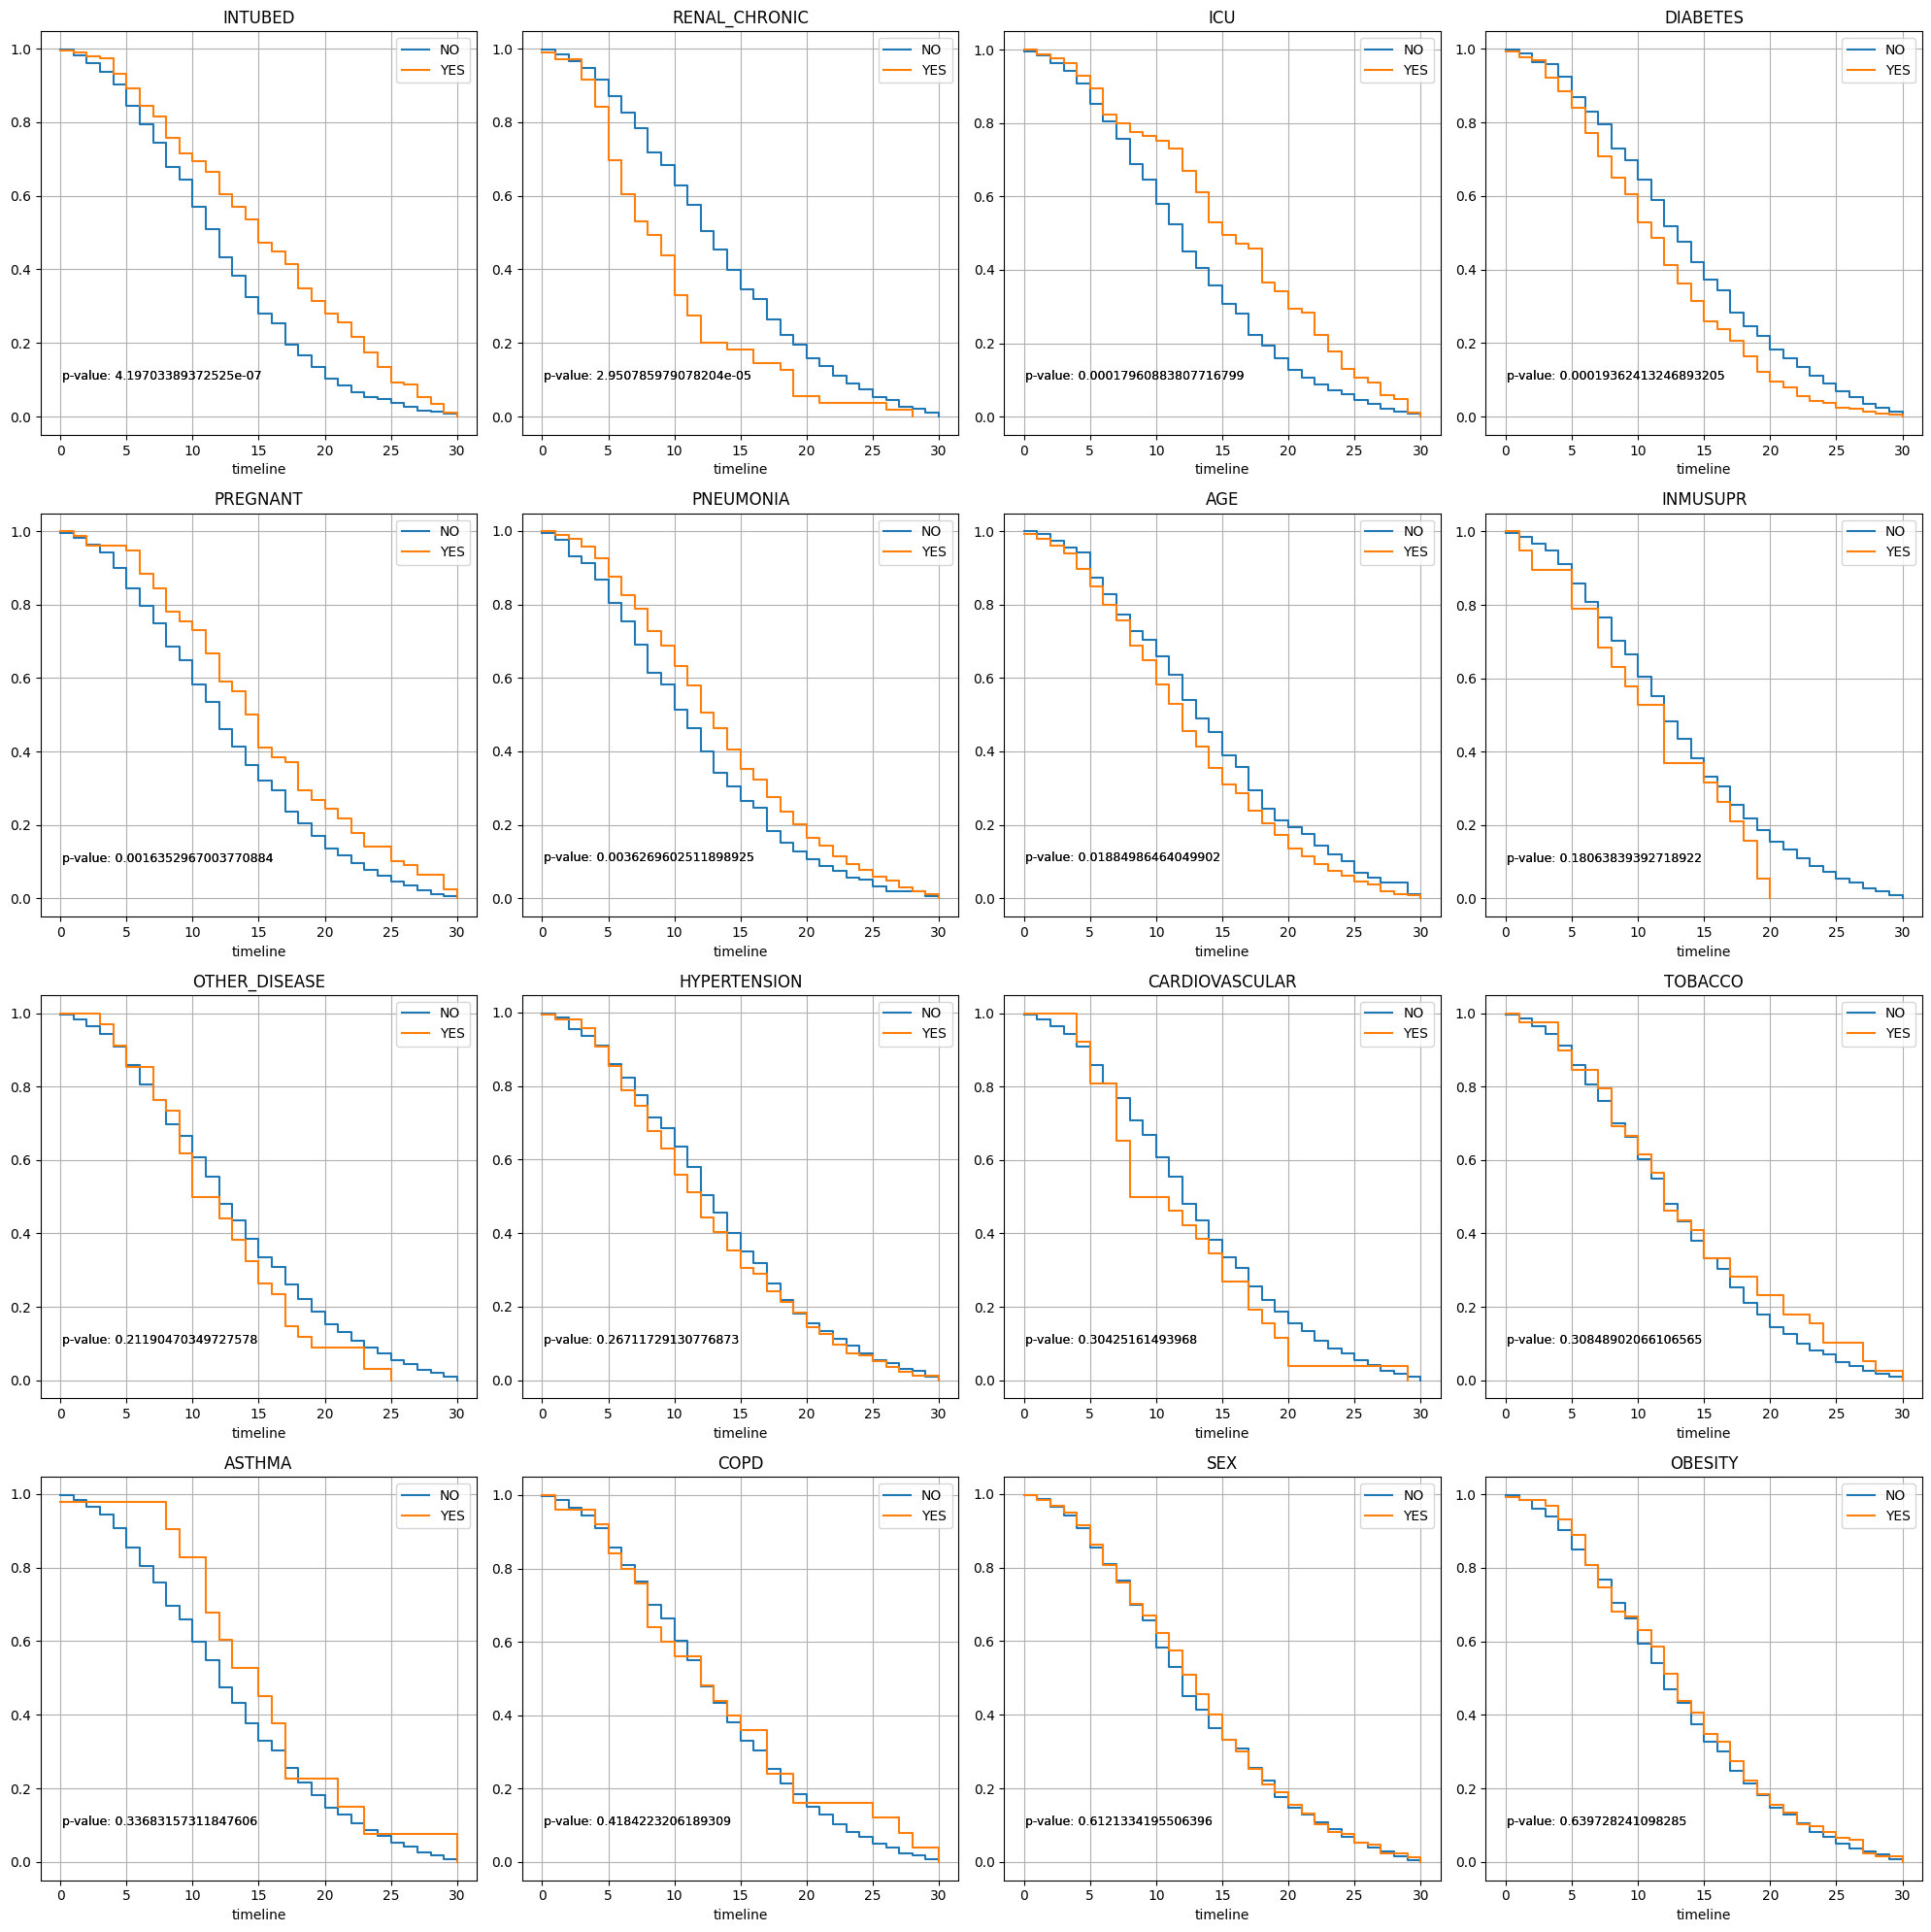

In [8]:
plt.figure(figsize=(20, 20))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        printGraph(df, pValues[i * 4 + j][0])
plt.tight_layout()
plt.show()